# Thư Viện

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import joblib
import unicodedata
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns  # Vẽ biểu đồ đẹp
import torch
import random
import statistics
import time
import pickle
import sys
import os

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB # áp dụng phân phối đa thức
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Tiền Xử Lí

In [4]:
df = pd.read_csv("/content/drive/MyDrive/CT294/VI_IMDB.csv")
# Loại bỏ cột không cần thiết
df.drop(['vi_review'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
# Mã hoá nhãn và lưu cột mapped_lables

label_map = {
    "positive": 1,
    "negative": 0
}

df["mapped_labels"] = df['sentiment'].map(label_map)
df.rename(columns={'sentiment': 'labels'}, inplace=True)
df.head()

,review,labels,mapped_labels
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [6]:
data = df.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review         50000 non-null  object
 1   labels         50000 non-null  object
 2   mapped_labels  50000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [7]:
def unicode_normalize(text):
    return unicodedata.normalize('NFC', text)

data['review'] = data['review'].apply(unicode_normalize)
data.head()

,review,labels,mapped_labels
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [8]:
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

data['review'] = data['review'].apply(remove_html_tags)
data.head()

<ipython-input-8-bbe730b5c218>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


,review,labels,mapped_labels
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [9]:
def remove_illegal_chars(text):
    ILLEGAL_CHARACTERS_RE = re.compile(r'[\000-\010\013\014\016-\037]')
    return ILLEGAL_CHARACTERS_RE.sub('', text)

data['review'] = data['review'].apply(remove_illegal_chars)
data.head()

,review,labels,mapped_labels
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [10]:
def clean_text(text):
    # Loại bỏ các ký tự đặc biệt bằng regex
    text = re.sub(r'[^a-zA-Z0-9\s.,]', '', text)
    return text.replace(',', ' ').replace('.', ' ')
data['review'] = data['review'].apply(clean_text)
data.head()

,review,labels,mapped_labels
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically theres a family where a little boy J...,negative,0
4,Petter Matteis Love in the Time of Money is a ...,positive,1


In [11]:
def to_lower(text):
    return text.lower()

data['review'] = data['review'].apply(to_lower)
data.head()

,review,labels,mapped_labels
0,one of the other reviewers has mentioned that ...,positive,1
1,a wonderful little production the filming tec...,positive,1
2,i thought this was a wonderful way to spend ti...,positive,1
3,basically theres a family where a little boy j...,negative,0
4,petter matteis love in the time of money is a ...,positive,1


In [12]:
nltk.download('stopwords')
# Tải stopwords tiếng Anh
eng_stopwords = set(stopwords.words('english'))

# Hàm để loại bỏ stopwords từ một văn bản
def remove_stopwords(text):
    # Tách văn bản thành các từ
    words = text.split()

    # Loại bỏ các từ là stopwords
    words = [word for word in words if word.lower() not in eng_stopwords]

    # Ghép các từ lại thành văn bản
    return ' '.join(words)

data['review'] = data['review'].apply(remove_stopwords)
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,review,labels,mapped_labels
0,one reviewers mentioned watching 1 oz episode ...,positive,1
1,wonderful little production filming technique ...,positive,1
2,thought wonderful way spend time hot summer we...,positive,1
3,basically theres family little boy jake thinks...,negative,0
4,petter matteis love time money visually stunni...,positive,1


In [13]:
# Tải dữ liệu cần thiết cho lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

# Khởi tạo WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Hàm để áp dụng lemmatization cho văn bản
def lemmatize_words(text):
    # Tách văn bản thành các từ
    words = text.split()

    # Áp dụng lemmatization cho mỗi từ
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Ghép các từ lại thành văn bản
    return ' '.join(lemmatized_words)

data['review'] = data['review'].apply(lemmatize_words)
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,review,labels,mapped_labels
0,one reviewer mentioned watching 1 oz episode y...,positive,1
1,wonderful little production filming technique ...,positive,1
2,thought wonderful way spend time hot summer we...,positive,1
3,basically there family little boy jake think t...,negative,0
4,petter matteis love time money visually stunni...,positive,1


In [14]:
sentences = [sentence.split() for sentence in data['review']]

# Tạo mô hình bigram

bigram_phrases = Phrases(sentences, min_count=3, threshold=2)
bigram_model = Phraser(bigram_phrases)

# Tạo mô hình trigram dựa trên bigram model
trigram_phrases = Phrases(bigram_model[sentences], min_count=2, threshold=2)
trigram_model = Phraser(trigram_phrases)

# Lưu mô hình bigram
bigram_model.save('bigram_model.pkl')

# Lưu mô hình trigram
trigram_model.save('trigram_model.pkl')

def apply_bigrams_trigrams_to_sentence(sentence, bigram_model, trigram_model):
    words = sentence.split()
    sentence_with_bigrams = bigram_model[words]
    sentence_with_trigrams = trigram_model[sentence_with_bigrams]
    return ' '.join(sentence_with_trigrams)

data['review'] = data['review'].apply(lambda x: apply_bigrams_trigrams_to_sentence(x, bigram_model, trigram_model))
data.head()

,review,labels,mapped_labels
0,one_reviewer mentioned watching 1 oz episode y...,positive,1
1,wonderful_little production filming_technique ...,positive,1
2,thought_wonderful way_spend time hot_summer we...,positive,1
3,basically there family little_boy jake think_t...,negative,0
4,petter matteis love time_money visually_stunni...,positive,1


In [15]:
data = data.groupby('review', as_index=False).agg({'labels': 'first', 'mapped_labels': 'first'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49575 entries, 0 to 49574
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review         49575 non-null  object
 1   labels         49575 non-null  object
 2   mapped_labels  49575 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


# Phân Tích Dữ Liệu

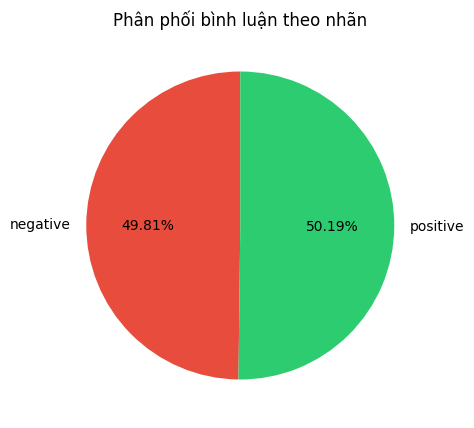

In [16]:
# Màu sắc cho các nhãn

label_colors = ['#E74C3C', '#2ECC71']

# Tạo danh sách các nhãn và số tương ứng từ label_map
labels = list(label_map.keys())
number_labels = list(label_map.values())
# Đếm số lượng xuất hiện của mỗi nhãn trong dữ liệu
label_counts = data['mapped_labels'].value_counts().reindex(number_labels[::-1])
plt.figure(figsize=(5, 5))

# Vẽ biểu đồ hình tròn với các nhãn và màu sắc tương ứng
plt.pie(label_counts, labels=labels[::-1], autopct='%1.2f%%', startangle=90, colors=label_colors)
plt.title('Phân phối bình luận theo nhãn')
plt.show()

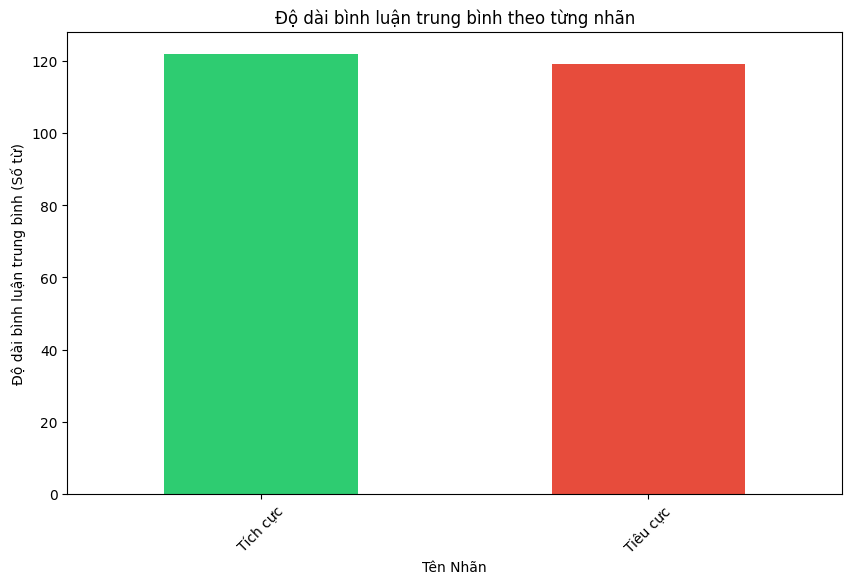

In [17]:
# Giả sử df là DataFrame của bạn
category_order = ['positive', 'negative']
temp = data.copy()

# Thay thế dấu gạch dưới bằng dấu cách trong cột review
temp['review'] = temp['review'].str.replace('_', ' ')

# Tính số lượng từ có trong 1 tiêu đề và lưu giá trị vào cột sentence_length
temp['sentence_length'] = temp['review'].apply(lambda x: len(x.split()))

# Thay thế tên nhãn
temp['labels'] = temp['labels'].replace({'positive': 'Tích cực', 'negative': 'Tiêu cực'})

# Cập nhật category_order với tên nhãn mới
category_order = ['Tích cực', 'Tiêu cực']

# Tính độ dài câu trung bình theo từng loại nhãn
average_sentence_length = temp.groupby('labels')['sentence_length'].mean().reindex(category_order)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
average_sentence_length.plot(kind='bar', color=['#2ECC71', '#E74C3C'])  # Màu xanh lá cho tích cực, đỏ cho tiêu cực
plt.title('Độ dài bình luận trung bình theo từng nhãn')
plt.xlabel('Tên Nhãn')
plt.ylabel('Độ dài bình luận trung bình (Số từ)')
plt.xticks(rotation=45)
plt.show()


In [18]:
temp_tkn_df = data.copy()
temp_tkn_df['review'] = temp_tkn_df['review'].apply(lambda x: [word.replace('_', ' ') for word in x.split()])

all_words = [word for title in temp_tkn_df['review'] for word in title]

word_frequency = {}
total_titles = len(temp_tkn_df)

for word in all_words:
    if word in word_frequency:
        word_frequency[word] += 1
    else:
        word_frequency[word] = 1

word_frequencies = {word: freq / total_titles for word, freq in word_frequency.items()}
# tần suất xuất hiện của các từ
word_frequency_df = pd.DataFrame(word_frequencies.items(), columns=['Từ', 'Tần suất'])
word_frequency_df = word_frequency_df.sort_values(by='Tần suất', ascending=False)
word_frequency_df = word_frequency_df.reset_index(drop=True)

word_frequency_df.head(10)

,Từ,Tần suất
0,movie,1.167221
1,film,1.104065
2,one,0.659808
3,like,0.391589
4,character,0.289662
5,time,0.288654
6,even,0.278991
7,story,0.258840
8,also,0.232012
9,see,0.224266


In [19]:
word_frequency_df.iloc[-11:-1][::-1]

,Từ,Tần suất
275115,perfectionthe,0.00002
275114,bodyhe,0.00002
275113,spoilersdr,0.00002
275112,volenteering,0.00002
275111,horrorgoreexploitation,0.00002
275110,manipulationa,0.00002
275109,livington,0.00002
275108,issuedriven,0.00002
275107,planck,0.00002
275106,bathedinlight,0.00002


# Trích Xuất Đặc Trưng

In [ ]:
# Bước 1: Tính toán TF-IDF cho văn bản
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True)
features = vectorizer.fit_transform(data['review'])

# Bước 2: Chọn lựa đặc trưng bằng Chi-Square
k = 10000  # Số lượng đặc trưng bạn muốn giữ lại

chi2_selector = SelectKBest(chi2, k=k)
selected_features = chi2_selector.fit_transform(features, data['mapped_labels'])

# Lấy tên các từ quan trọng được chọn
selected_feature_names = vectorizer.get_feature_names_out()[chi2_selector.get_support()]

# Bước 3: Chuyển selected_features thành DataFrame và thêm nhãn
tfidf_data = pd.DataFrame(data=selected_features.toarray(), columns=selected_feature_names)
tfidf_data['mapped_labels'] = data['mapped_labels']

# Xem trước dữ liệu sau khi chọn lựa đặc trưng
tfidf_data.info()
tfidf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49575 entries, 0 to 49574
Columns: 10001 entries, 007 to mapped_labels
dtypes: float64(10000), int64(1)
memory usage: 3.7 GB


,007,010,0_10,0_star,1000_time,100_greatest,100_minute,1010,1010_bethany_cox,1010_star,...,zoey,zoey_101,zombie,zombie_action,zombie_film,zombie_flick,zombie_movie,zoom,zucco,mapped_labels
0,0.0,0.156992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Train Test Split

In [ ]:
X = tfidf_data.drop(columns=['mapped_labels']).values
y = tfidf_data['mapped_labels'].values
# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (39660, 10000)
y_train shape: (39660,)


# Huấn luyện mô hình

In [ ]:
def calc_all_scores(y_test, y_test_pred, y_train, y_train_pred):
    print("train")
    accuracy_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='binary', pos_label=0)
    precision_train = precision_score(y_train, y_train_pred, average='binary', pos_label=0)
    recall_train = recall_score(y_train, y_train_pred, average='binary', pos_label=0)
    cf_matrix_train = confusion_matrix(y_train, y_train_pred)
    print(f'Accuracy: {accuracy_train}')
    print(f'Precision: {precision_train}')
    print(f'Recall: {recall_train}')
    print(f'F1 score: {f1_train}')
    print(cf_matrix_train)

    print("test")
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='binary', pos_label=0)
    precision_test = precision_score(y_test, y_test_pred, average='binary', pos_label=0)
    recall_test = recall_score(y_test, y_test_pred, average='binary', pos_label=0)
    cf_matrix_test = confusion_matrix(y_test, y_test_pred)
    print(f'Accuracy: {accuracy_test}')
    print(f'Precision: {precision_test}')
    print(f'Recall: {recall_test}')
    print(f'F1 score: {f1_test}')
    print(cf_matrix_test)
    print()
    print('----------------------------------------------------------------')
    print()

    return f1_train, f1_test

In [ ]:
def draw_chart_for_normal_params(values, train_recalls, test_recalls, model_name, param_name, rotation=None):
    plt.figure(figsize=(10, 6))
    plt.plot(values, train_recalls, marker='o', label='Training F1')
    plt.plot(values, test_recalls, marker='o', label='Test F1')
    plt.xlabel(param_name)
    plt.ylabel('F1')
    plt.title(f"Training and Test F1 For {model_name}")
    if rotation is not None:
        plt.xticks(values, rotation=rotation)  # Đảm bảo hiển thị tất cả các giá trị của alpha_values
    else:
        plt.xticks(values)
    plt.grid(True)
    plt.legend()
    plt.savefig(f'/kaggle/working/{model_name}.jpg', format='jpg', dpi=300)
    plt.show()

def draw_chart_for_log_param(values, train_recalls, test_recalls, model_name, param_name):
    plt.figure(figsize=(10, 6))
    plt.semilogx(values, train_recalls, marker='o', label='Training F1')
    plt.semilogx(values, test_recalls, marker='o', label='Test F1')
    plt.xlabel(param_name)
    plt.ylabel('F1')
    plt.title(f"Training and Test F1 For {model_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(f'/kaggle/working/{model_name}.jpg', format='jpg', dpi=300)
    plt.show()

def draw_chart_for_n_trials(values, accs, pres, recs, f1s, model_name, param_name, is_log=False, rotation=None):
    plt.figure(figsize=(10, 6))
    if is_log:
        plt.semilogx(values, accs, marker='o', label='Accuracy')
        plt.semilogx(values, pres, marker='o', label='Precision')
        plt.semilogx(values, recs, marker='o', label='Recall')
        plt.semilogx(values, f1s, marker='o', label='F1')
    else:
        plt.plot(values, accs, marker='o', label='Accuracy')
        plt.plot(values, pres, marker='o', label='Precision')
        plt.plot(values, recs, marker='o', label='Recall')
        plt.plot(values, f1s, marker='o', label='F1')

    plt.xlabel(param_name)
    plt.ylabel('%')
    plt.title(f"Test For {model_name}")

    if rotation is not None:
        plt.xticks(values, rotation=rotation)  # Đảm bảo hiển thị tất cả các giá trị của alpha_values
    else:
        plt.xticks(values)
    plt.grid(True)
    plt.legend()
    plt.show()


## KNN

metric = euclidean - k = 9:
train
Accuracy: 0.7096570852244075
Precision: 0.6315755668315242
Recall: 0.9978182556192602
F1 score: 0.7735362951599898
[[19666    43]
 [11472  8479]]
test
Accuracy: 0.5466464952092789
Precision: 0.5283651068746389
Recall: 0.9171680705976735
F1 score: 0.6704787039073381
[[4573  413]
 [4082  847]]

----------------------------------------------------------------

metric = euclidean - k = 13:
train
Accuracy: 0.7141452344931921
Precision: 0.6381153490827505
Recall: 0.981277588918768
F1 score: 0.7733370653977648
[[19340   369]
 [10968  8983]]
test
Accuracy: 0.556530509329299
Precision: 0.5363266313062786
Recall: 0.8720417168070598
F1 score: 0.6641716947987474
[[4348  638]
 [3759 1170]]

----------------------------------------------------------------

metric = euclidean - k = 29:
train
Accuracy: 0.6401412002017146
Precision: 0.8242098986285032
Recall: 0.3506519864021513
F1 score: 0.4919911724923471
[[ 6911 12798]
 [ 1474 18477]]
test
Accuracy: 0.539183055975794

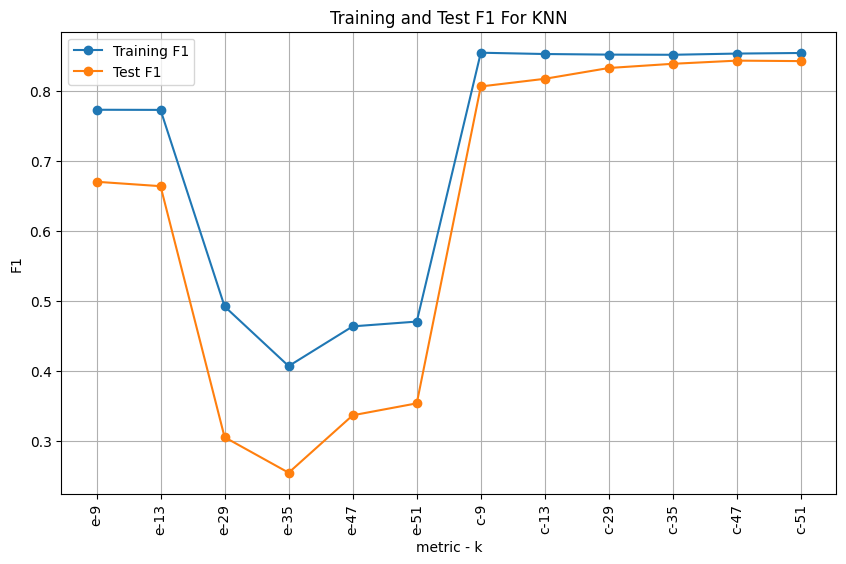

In [ ]:
k_values = [9, 13, 29, 35, 47, 51]
metric_list = ['euclidean', 'cosine']

train_recalls = []
test_recalls = []
param_values = []

for metric in metric_list:
    for k in k_values:
        print(f'metric = {metric} - k = {k}:')
        clf = KNeighborsClassifier(n_neighbors=k, metric=metric)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        train_recall, test_recall = calc_all_scores(y_test, y_test_pred, y_train, y_train_pred)

        train_recalls.append(train_recall)
        test_recalls.append(test_recall)

        param_values.append(f"{metric[0]}-{k}")

draw_chart_for_normal_params(param_values, train_recalls, test_recalls, 'KNN', 'metric - k', rotation=90)

## Multinomial Naive Bayes

alpha = 0.0001:
train
Accuracy: 0.9311144730206757
Precision: 0.9369434292479539
Recall: 0.9235374701912832
F1 score: 0.9301921504497137
[[18202  1507]
 [ 1225 18726]]
test
Accuracy: 0.9096318709026727
Precision: 0.9148073022312373
Recall: 0.9045326915363017
F1 score: 0.9096409842678499
[[4510  476]
 [ 420 4509]]

----------------------------------------------------------------

alpha = 0.001:
train
Accuracy: 0.9307362581946546
Precision: 0.9365348980852378
Recall: 0.9231823025013953
F1 score: 0.9298106650995221
[[18195  1514]
 [ 1233 18718]]
test
Accuracy: 0.9107413010590015
Precision: 0.9160073037127207
Recall: 0.9055354993983152
F1 score: 0.9107413010590014
[[4515  471]
 [ 414 4515]]

----------------------------------------------------------------

alpha = 0.01:
train
Accuracy: 0.9293242561775088
Precision: 0.9353177464208466
Recall: 0.921507940534781
F1 score: 0.9283614895085235
[[18162  1547]
 [ 1256 18695]]
test
Accuracy: 0.9121533030761473
Precision: 0.917766497461929
Recall: 0

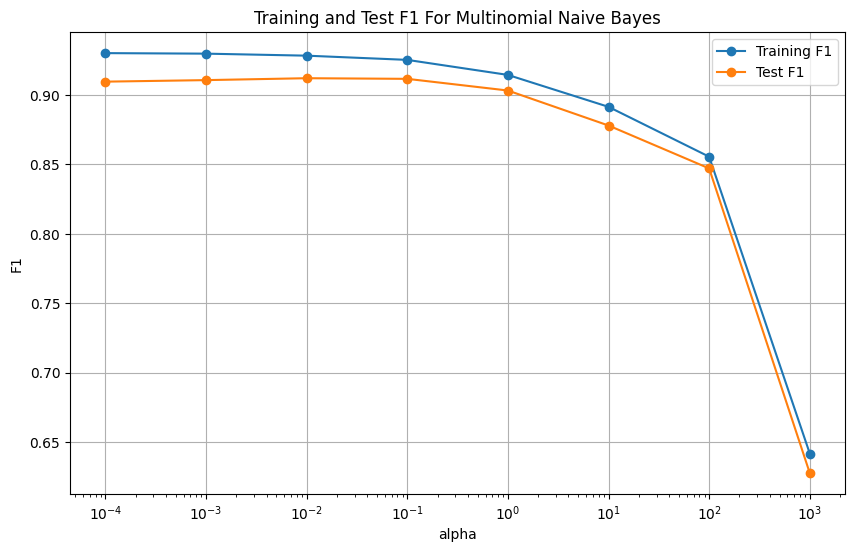

In [ ]:
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_recalls = []
test_recalls = []

for alpha in alpha_values:
    clf = MultinomialNB(alpha=alpha, fit_prior=True)
    print(f'alpha = {alpha}:')
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_recall, test_recall = calc_all_scores(y_test, y_test_pred, y_train, y_train_pred)
    train_recalls.append(train_recall)

    test_recalls.append(test_recall)

draw_chart_for_log_param(alpha_values, train_recalls, test_recalls, "Multinomial Naive Bayes", 'alpha')

## Decision Tree

DesicionTreeClassifier(criterion=entropy, max_depth=30, min_samples_leaf=20)

Accuracy: 0.6731215330307615
Precision: 0.741890767951206
Recall: 0.5367027677496992
F1 score: 0.622832538112417
[[2676 2310]
 [ 931 3998]]

----------------------------------------------------------------

DesicionTreeClassifier(criterion=entropy, max_depth=40, min_samples_leaf=20)

Accuracy: 0.686938981341402
Precision: 0.7416538263995891
Recall: 0.5792218210990774
F1 score: 0.6504504504504505
[[2888 2098]
 [1006 3923]]

----------------------------------------------------------------

DesicionTreeClassifier(criterion=entropy, max_depth=50, min_samples_leaf=20)

Accuracy: 0.6967221381744831
Precision: 0.7219107423189056
Recall: 0.6456077015643803
F1 score: 0.681630492323981
[[3219 1767]
 [1240 3689]]

----------------------------------------------------------------

DesicionTreeClassifier(criterion=entropy, max_depth=60, min_samples_leaf=20)

Accuracy: 0.7010590015128593
Precision: 0.7295640326975477
Recall

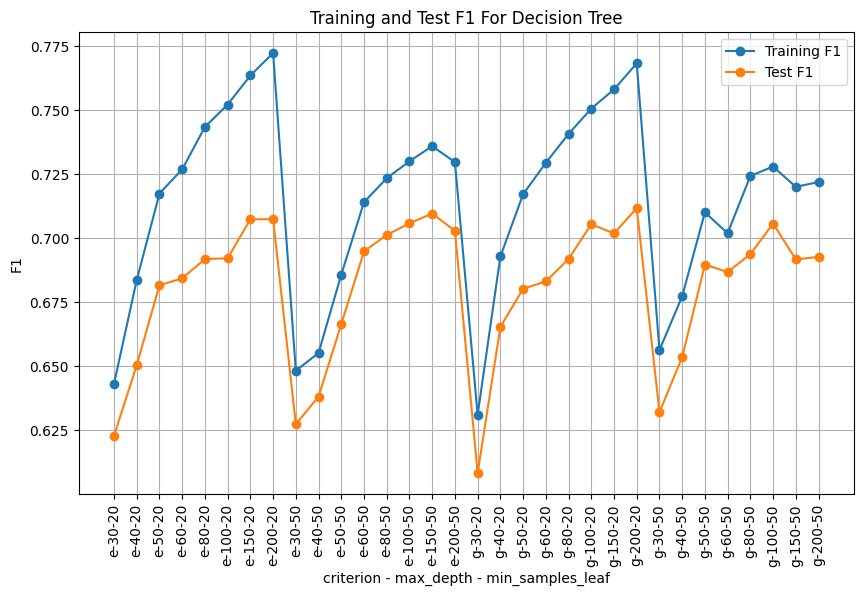

In [ ]:
criterions_list = ['entropy', 'gini']
max_depth_list = [30, 40, 50, 60, 80, 100, 150, 200]
min_samples_list = [20, 50]

train_recalls = []
test_recalls = []
param_values = []

for criterion in criterions_list:
    for min_samples in min_samples_list:
        for max_depth in max_depth_list:
                clf = DecisionTreeClassifier(criterion=criterion,

                                             max_depth=max_depth,

                                             min_samples_leaf=min_samples, max_features=1000)
                key = f"DesicionTreeClassifier(criterion={criterion}, max_depth={max_depth}, min_samples_leaf={min_samples})"
                print(f"{key}\n")
                param_values.append(f"{criterion[0]}-{max_depth}-{min_samples}")
                clf.fit(X_train, y_train)

                y_train_pred = clf.predict(X_train)
                y_test_pred = clf.predict(X_test)

                train_recall, test_recall = calc_all_scores(y_test, y_test_pred, y_train, y_train_pred)
                train_recalls.append(train_recall)
                test_recalls.append(test_recall)

draw_chart_for_normal_params(param_values, train_recalls, test_recalls, "Decision Tree", 'criterion - max_depth - min_samples_leaf', 90)


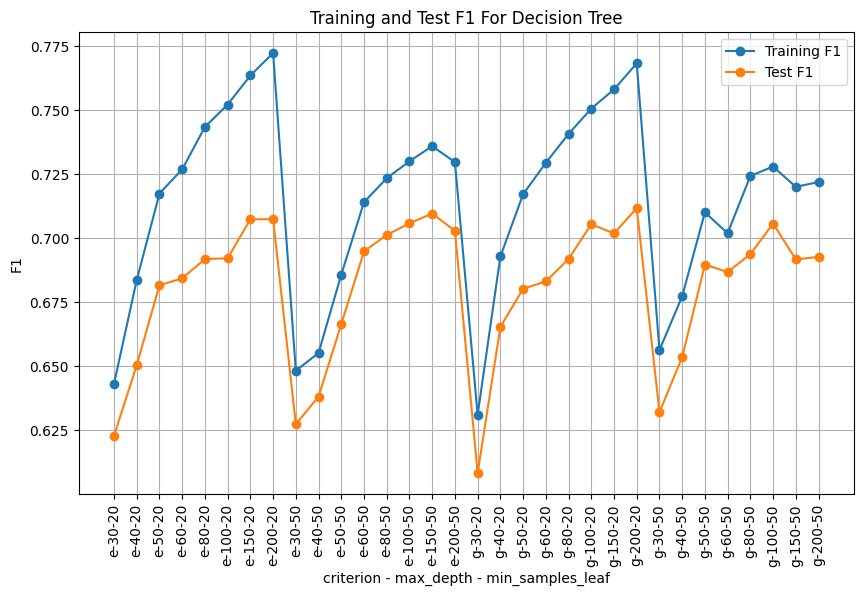

In [ ]:
draw_chart_for_normal_params(param_values, train_recalls, test_recalls, "Decision Tree", 'criterion - max_depth - min_samples_leaf', 90)

## Linear SVC

C = 0.0001:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train
Accuracy: 0.5030509329299042
Precision: 0.0
Recall: 0.0
F1 score: 0.0
[[    0 19709]
 [    0 19951]]
test
Accuracy: 0.49712556732223906
Precision: 0.0
Recall: 0.0
F1 score: 0.0
[[   0 4986]
 [   0 4929]]

----------------------------------------------------------------

C = 0.001:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train
Accuracy: 0.5030509329299042
Precision: 0.0
Recall: 0.0
F1 score: 0.0
[[    0 19709]
 [    0 19951]]
test
Accuracy: 0.49712556732223906
Precision: 0.0
Recall: 0.0
F1 score: 0.0
[[   0 4986]
 [   0 4929]]

----------------------------------------------------------------

C = 0.01:
train
Accuracy: 0.5036056480080686
Precision: 1.0
Recall: 0.0011162413110761581
F1 score: 0.002229993411383103
[[   22 19687]
 [    0 19951]]
test
Accuracy: 0.49742813918305595
Precision: 1.0
Recall: 0.0006016847172081829
F1 score: 0.0012026458208057728
[[   3 4983]
 [   0 4929]]

----------------------------------------------------------------

C = 0.1:
train
Accuracy: 0.8691628845184065
Precision: 0.8958128884527314
Recall: 0.8336800446496524
F1 score: 0.8636303907913064
[[16431  3278]
 [ 1911 18040]]
test
Accuracy: 0.854261220373172
Precision: 0.8836403033586132
Recall: 0.8178900922583233
F1 score: 0.8494948442870535
[[4078  908]
 [ 537 4392]]

---------------------------------------------------------

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


train
Accuracy: 0.9916792738275341
Precision: 0.9925779065629607
Recall: 0.9906641635800904
F1 score: 0.9916201117318436
[[19525   184]
 [  146 19805]]
test
Accuracy: 0.8536560766515381
Precision: 0.8557053733145502
Recall: 0.8527878058563979
F1 score: 0.8542440984429935
[[4252  734]
 [ 717 4212]]

----------------------------------------------------------------



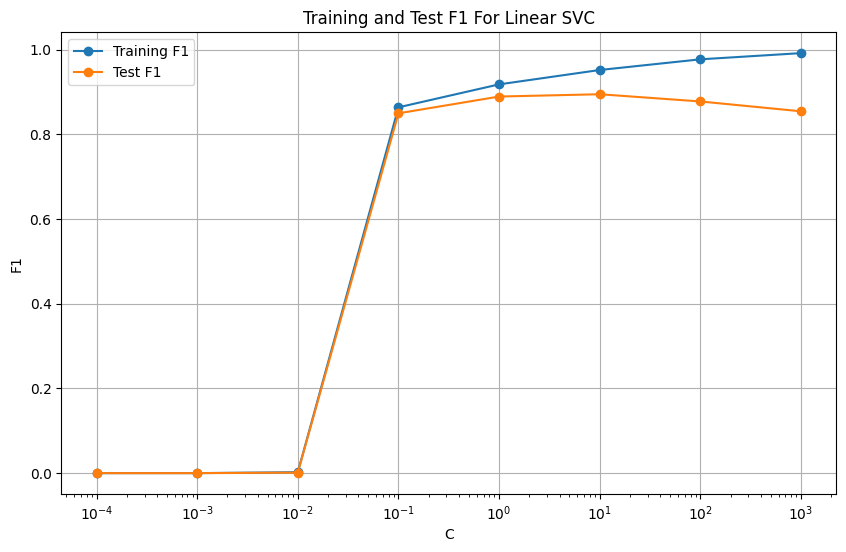

In [ ]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

train_recalls = []

test_recalls = []





for C in C_values:

    clf = LinearSVC(C=C, loss='hinge', max_iter=100000)

    print(f'C = {C}:')

    clf.fit(X_train, y_train)



    y_train_pred = clf.predict(X_train)

    y_test_pred = clf.predict(X_test)



    train_recall, test_recall = calc_all_scores(y_test, y_test_pred, y_train, y_train_pred)

    train_recalls.append(train_recall)

    test_recalls.append(test_recall)



draw_chart_for_log_param(C_values, train_recalls, test_recalls, "Linear SVC", 'C')

## Logistic Regression

C = 0.0001:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train
Accuracy: 0.5030509329299042
Precision: 0.0
Recall: 0.0
F1 score: 0.0
[[    0 19709]
 [    0 19951]]
test
Accuracy: 0.49712556732223906
Precision: 0.0
Recall: 0.0
F1 score: 0.0
[[   0 4986]
 [   0 4929]]

----------------------------------------------------------------

C = 0.001:
train
Accuracy: 0.6125063035804337
Precision: 0.979456593770709
Recall: 0.2249733624232584
F1 score: 0.36590196402046543
[[ 4434 15275]
 [   93 19858]]
test
Accuracy: 0.6081694402420574
Precision: 0.9774501300954033
Recall: 0.22603289209787406
F1 score: 0.3671607753705815
[[1127 3859]
 [  26 4903]]

----------------------------------------------------------------

C = 0.01:
train
Accuracy: 0.8300302571860817
Precision: 0.8834871066950556
Recall: 0.7579278502207113
F1 score: 0.8159051806537947
[[14938  4771]
 [ 1970 17981]]
test
Accuracy: 0.82178517397882
Precision: 0.8823948681397007
Recall: 0.7448856799037304
F1 score: 0.8078303425774878
[[3714 1272]
 [ 495 4434]]

-------------------------------------

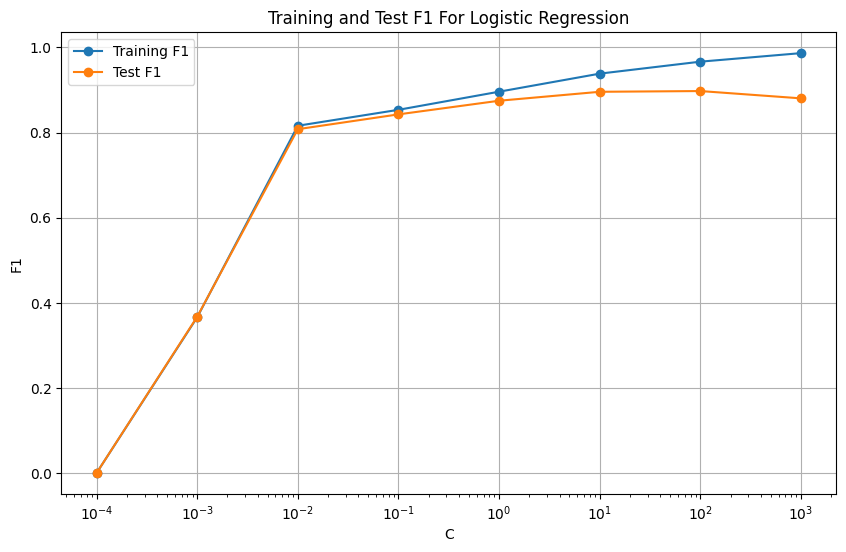

In [ ]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

train_recalls = []

test_recalls = []





for C in C_values:

    clf = LogisticRegression(C=C, penalty='l2', solver='liblinear', max_iter=1000, random_state=42)

    print(f'C = {C}:')

    clf.fit(X_train, y_train)



    y_train_pred = clf.predict(X_train)

    y_test_pred = clf.predict(X_test)



    train_recall, test_recall = calc_all_scores(y_test, y_test_pred, y_train, y_train_pred)

    train_recalls.append(train_recall)

    test_recalls.append(test_recall)



draw_chart_for_log_param(C_values, train_recalls, test_recalls, "Logistic Regression", 'C')

## Random Forest

RandomForest(n_estimators=100, max_depth=10, min_samples_leaf=20)

train
Accuracy: 0.8027231467473525
Precision: 0.9028540437936411
Recall: 0.6757318991323761
F1 score: 0.7729541497388276
[[13318  6391]
 [ 1433 18518]]
test
Accuracy: 0.77327281896117
Precision: 0.8752741228070176
Recall: 0.6403931006819094
F1 score: 0.7396340050961315
[[3193 1793]
 [ 455 4474]]

----------------------------------------------------------------

RandomForest(n_estimators=100, max_depth=20, min_samples_leaf=20)

train
Accuracy: 0.8587745839636913
Precision: 0.917396449704142
Recall: 0.7866456948602162
F1 score: 0.8470048348766698
[[15504  4205]
 [ 1396 18555]]
test
Accuracy: 0.8147251638930912
Precision: 0.8740793537657401
Recall: 0.7378660248696349
F1 score: 0.8002175095160413
[[3679 1307]
 [ 530 4399]]

----------------------------------------------------------------

RandomForest(n_estimators=100, max_depth=30, min_samples_leaf=20)

train
Accuracy: 0.8883257690368129
Precision: 0.931199909696354
Recall

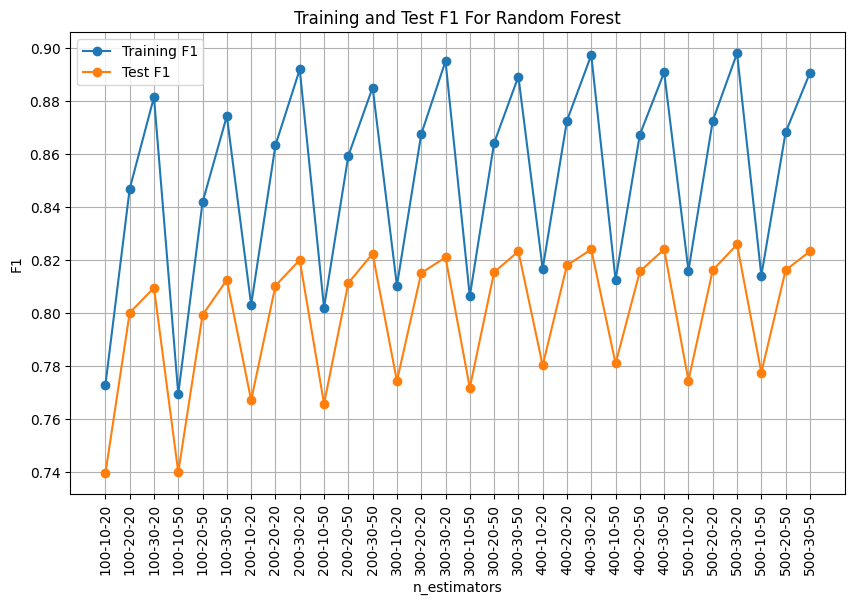

In [ ]:
n_values = range(100, 501, 100)



max_depth_list = [10, 20, 30]

min_samples_list = [20, 50]



train_recalls = []

test_recalls = []

param_values = []





for n in n_values:

    for min_samples in min_samples_list:

        for max_depth in max_depth_list:

            clf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_split=min_samples, max_features='log2', random_state=42)

            clf.fit(X_train, y_train)



            key = f"RandomForest(n_estimators={n}, max_depth={max_depth}, min_samples_leaf={min_samples})"

            print(f"{key}\n")

            param_values.append(f"{n}-{max_depth}-{min_samples}")



            y_train_pred = clf.predict(X_train)

            y_test_pred = clf.predict(X_test)



            train_recall, test_recall = calc_all_scores(y_test, y_test_pred, y_train, y_train_pred)

            train_recalls.append(train_recall)

            test_recalls.append(test_recall)



draw_chart_for_normal_params(param_values, train_recalls, test_recalls, "Random Forest", 'n_estimators - max_depth - min_samples_leaf', 90)




# Chạy mô hình với các tham số cho độ chính xác cao

In [ ]:
import sys



def get_model_size(model, model_name=None):

    if model_name == 'Fast Text':

        path = f'/kaggle/working/{model_name}.bin'

        model.save_model(path)

        return os.path.getsize(path) / (1024 * 1024)

    serialized_model = pickle.dumps(model)

    return sys.getsizeof(serialized_model) / (1024 * 1024)  # kích thước tính bằng MB

In [ ]:
v_chi_model_size = get_model_size(vectorizer) + get_model_size(chi2_selector)

print(v_chi_model_size)

6.905793190002441


In [ ]:
def evaluate_holdout(model_name, X, y, k=None, alpha=None, C=None, criterion=None, max_depth=None, min_samples_leaf=None, n_estimators=None, epoch=None, lr=None, test_size=0.2):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    if model_name == 'KNN':

        model = KNeighborsClassifier(n_neighbors=k, metric='cosine')

    elif model_name == 'MNB':

        model = MultinomialNB(alpha=alpha, fit_prior=True)

    elif model_name == 'Decision Tree':

        model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, max_features=1000)

    elif model_name == 'Linear SVC':

        model = LinearSVC(C=C, loss='hinge', max_iter=100000)

    elif model_name == 'Logistic Regression':

        model = LogisticRegression(C=C, penalty='l2', solver='liblinear', max_iter=1000, random_state=42)

    elif model_name == 'Random Forest':

        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, max_features='log2', random_state=42)

    elif model_name == 'Fast Text':

        model = FastTextClassifier('/kaggle/working/fasttext_data.txt', lr, epoch, wordNgrams=2, dim=200, verbose=1)



    start_train = time.time()

    model.fit(X_train, y_train)

    end_train = time.time()



    start_test = time.time()

    y_pred = model.predict(X_test)

    end_test = time.time()



    accuracy = accuracy_score(y_test, y_pred)

    f1 = f1_score(y_test, y_pred, average='binary', pos_label=0)

    precision = precision_score(y_test, y_pred, average='binary', pos_label=0)

    recall = recall_score(y_test, y_pred, average='binary', pos_label=0)



    train_time = end_train - start_train

    test_time = end_test - start_test



    return accuracy, f1, precision, recall, train_time, test_time / len(y_pred), get_model_size(model, model_name)

In [ ]:
def run_experiments(model_name, X, y, n_trials, k=None, alpha=None, C=None, criterion=None, max_depth=None, min_samples_leaf=None, n_estimators=None, epoch=None, lr=None):

    accuracy, f1, precision, recall = [], [], [], []

    train_times, test_times = [], []

    models_size = []

    for i in range(n_trials):

        # Trộn dữ liệu

        combined = list(zip(X, y))

        random.shuffle(combined)

        X_shuffled, y_shuffled = zip(*combined)

        X_shuffled, y_shuffled = np.array(X_shuffled), np.array(y_shuffled)



        # Đánh giá với Hold-Out

        acc, f1_score, prec, rec, train_time, test_time,model_size = evaluate_holdout(

                                                                        model_name, X_shuffled, y_shuffled,

                                                                        k, # KNN

                                                                        alpha, # MNB

                                                                        C, # SVC + LR

                                                                        criterion, max_depth, min_samples_leaf, # DTree

                                                                        n_estimators, # RF

                                                                        epoch, lr, # FT

                                                                    )

        accuracy.append(acc)

        f1.append(f1_score)

        precision.append(prec)

        recall.append(rec)

        train_times.append(train_time)

        test_times.append(test_time)

        models_size.append(model_size)



    # Tính giá trị trung bình cuối cùng



    accuracy_mean = statistics.mean(accuracy)

    f1_mean = statistics.mean(f1)

    precision_mean = statistics.mean(precision)

    recall_mean = statistics.mean(recall)



    train_time_mean = statistics.mean(train_times)

    test_time_mean = statistics.mean(test_times)

    model_size_mean = statistics.mean(models_size)



    print("Accuracy Hold-Out: ", accuracy_mean)

    print("F1 Hold-Out: ", f1_mean)

    print("Precision Hold-Out: ", precision_mean)

    print("Recall Hold-Out: ", recall_mean)

    print(f"Average Train Time Hold-Out: {train_time_mean:.4f} seconds")

    print(f"Average Test Time (for 1 sample) Hold-Out: {test_time_mean:.10f} seconds")

    print(f"Model Size Hold-Out: {model_size_mean:.4f} MB")

    data = {

        'Accuracy_Hold': accuracy,

        'F1_Hold': f1,

        'Precision_Hold': precision,

        'Recall_Hold': recall,

        'Train_Time_Hold': train_times,

        'Test_Time_Hold': test_times,

        'Model_Size_Hold': models_size

    }



    dfs = pd.DataFrame(data)

    dfs.to_excel(f"/kaggle/working/{model_name}.xlsx", index=False)

    return accuracy_mean, precision_mean, recall_mean, f1_mean

## KNN

--------------------
Mô Hình KNN với k = 29

Accuracy Hold-Out:  0.8450630358043368
F1 Hold-Out:  0.830607390826885
Precision Hold-Out:  0.9118708799401
Recall Hold-Out:  0.762708958643281
Average Train Time Hold-Out: 0.3563 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0127314760 seconds
Model Size Hold-Out: 3026.1211 MB

--------------------
Mô Hình KNN với k = 35

Accuracy Hold-Out:  0.8485526979324256
F1 Hold-Out:  0.8350929917091948
Precision Hold-Out:  0.9156102366588798
Recall Hold-Out:  0.7676075693061111
Average Train Time Hold-Out: 0.3310 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0127472642 seconds
Model Size Hold-Out: 3026.1211 MB

--------------------
Mô Hình KNN với k = 47

Accuracy Hold-Out:  0.8536258194654563
F1 Hold-Out:  0.8408161471916138
Precision Hold-Out:  0.9141654765773455
Recall Hold-Out:  0.7784084128019456
Average Train Time Hold-Out: 0.3190 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0126962494 seconds
Model Size Hold-Out: 3026.121

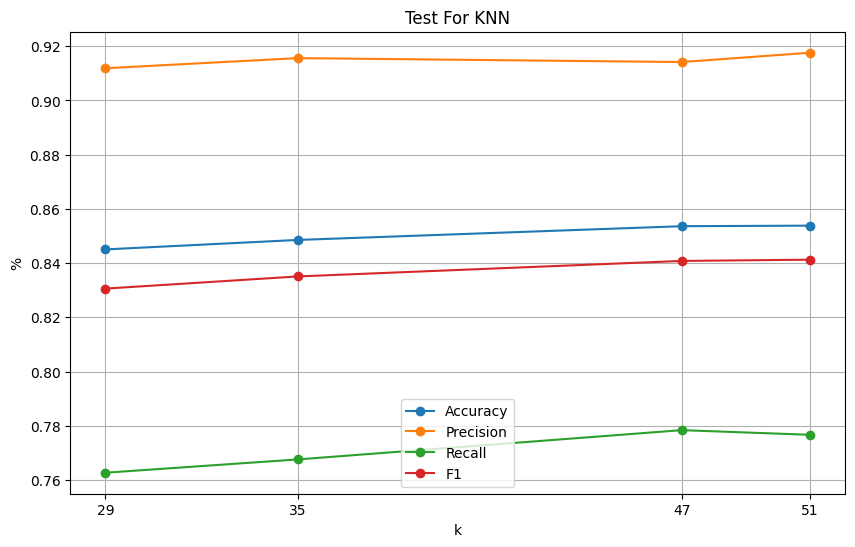

In [ ]:
values_k = [29, 35, 47, 51]



accs, pres, recs, f1s = [], [], [], []



for k in values_k:

    print("--------------------")

    print(f"Mô Hình KNN với k = {k}")

    print()

    acc, pre, rec, f1 = run_experiments(model_name="KNN", X=X, y=y, n_trials=10, k=k)



    accs.append(acc)

    pres.append(pre)

    recs.append(rec)

    f1s.append(f1)

    print()



draw_chart_for_n_trials(values_k, accs, pres, recs, f1s, "KNN", "k")

## Multinomial Naive Bayes

--------------------
Mô Hình MNB với alpha = 0.0001

Accuracy Hold-Out:  0.9133635905194151
F1 Hold-Out:  0.9123188372944271
Precision Hold-Out:  0.9166314544434498
Recall Hold-Out:  0.9080662266689695
Average Train Time Hold-Out: 1.1504 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0000226804 seconds
Model Size Hold-Out: 0.3058 MB

--------------------
Mô Hình MNB với alpha = 0.001

Accuracy Hold-Out:  0.9144730206757439
F1 Hold-Out:  0.913781790490338
Precision Hold-Out:  0.9189489398190928
Recall Hold-Out:  0.9086932823719724
Average Train Time Hold-Out: 1.1186 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0000230118 seconds
Model Size Hold-Out: 0.3058 MB

--------------------
Mô Hình MNB với alpha = 0.01

Accuracy Hold-Out:  0.9159959657085224
F1 Hold-Out:  0.9153565493008604
Precision Hold-Out:  0.9222988560284224
Recall Hold-Out:  0.9085549675031445
Average Train Time Hold-Out: 1.1582 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0000227526 seconds
Model Size

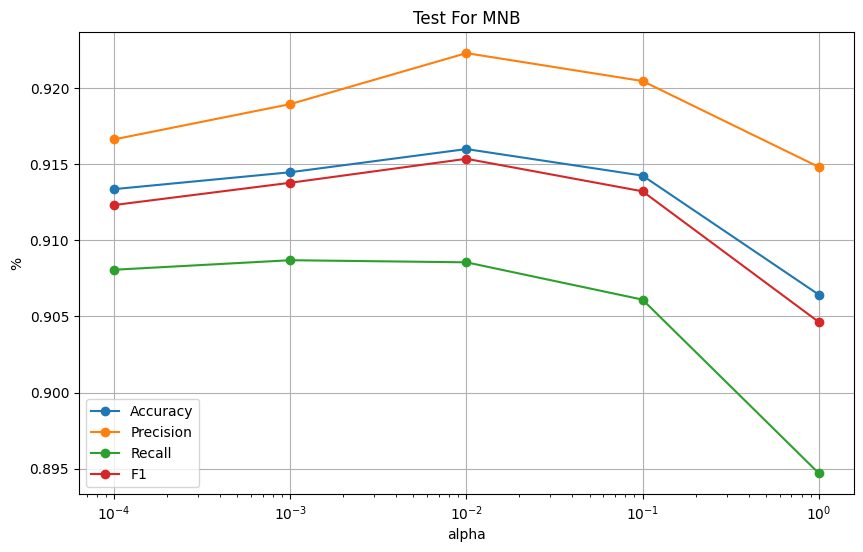

In [ ]:
alpha_values = [0.0001 ,0.001, 0.01, 0.1, 1]



accs, pres, recs, f1s = [], [], [], []



for alpha in alpha_values:

    print("--------------------")

    print(f"Mô Hình MNB với alpha = {alpha}")

    print()

    acc, pre, rec, f1 = run_experiments(model_name="MNB", X=X, y=y, n_trials=10, alpha=alpha)



    accs.append(acc)

    pres.append(pre)

    recs.append(rec)

    f1s.append(f1)

    print()



draw_chart_for_n_trials(alpha_values, accs, pres, recs, f1s, "MNB", "alpha", is_log=True)

## Decision Tree

--------------------
Mô Hình Decision Tree với criterion=entropy, max_depth=80 và min_samples_leaf=50

Accuracy Hold-Out:  0.7006757438224912
F1 Hold-Out:  0.6944371342394821
Precision Hold-Out:  0.7058191466621375
Recall Hold-Out:  0.6836297182164245
Average Train Time Hold-Out: 19.3307 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0000217227 seconds
Model Size Hold-Out: 0.0464 MB

--------------------
Mô Hình Decision Tree với criterion=entropy, max_depth=100 và min_samples_leaf=50

Accuracy Hold-Out:  0.7021079172970247
F1 Hold-Out:  0.6986253175091592
Precision Hold-Out:  0.6996529533426452
Recall Hold-Out:  0.6978806910011275
Average Train Time Hold-Out: 19.4413 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0000219558 seconds
Model Size Hold-Out: 0.0491 MB

--------------------
Mô Hình Decision Tree với criterion=gini, max_depth=80 và min_samples_leaf=50

Accuracy Hold-Out:  0.6983257690368129
F1 Hold-Out:  0.6937423274904678
Precision Hold-Out:  0.6982737391909585
R

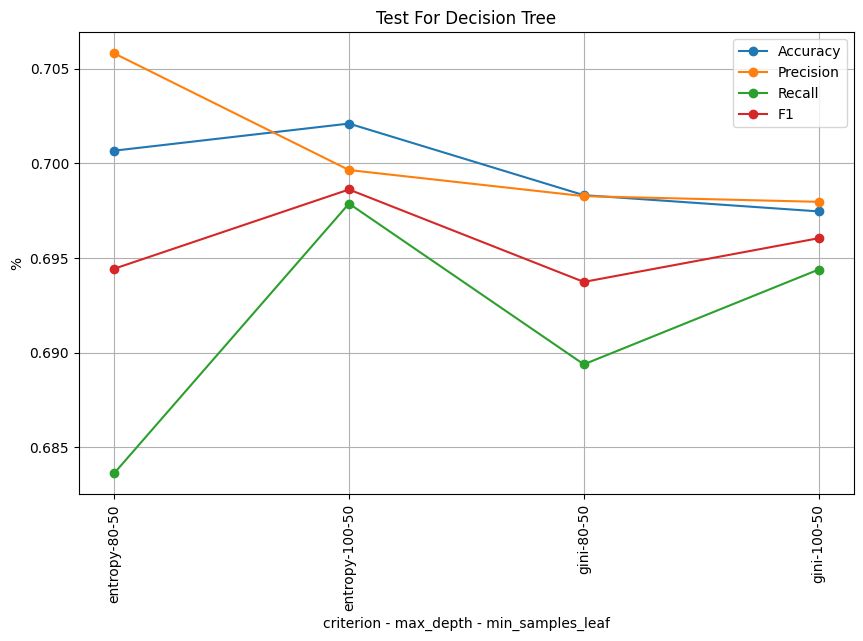

In [ ]:
params = [

    ['entropy', 80, 50],

    ['entropy', 100, 50],

    ['gini', 80, 50],

    ['gini', 100, 50]

]



params_values = []



accs, pres, recs, f1s = [], [], [], []



for param in params:

    print("--------------------")

    print(f"Mô Hình Decision Tree với criterion={param[0]}, max_depth={param[1]} và min_samples_leaf={param[2]}")

    print()

    acc, pre, rec, f1 = run_experiments(model_name="Decision Tree", X=X, y=y, n_trials=10,

                                        criterion=param[0],

                                        max_depth=param[1],

                                        min_samples_leaf=param[2])



    accs.append(acc)

    pres.append(pre)

    recs.append(rec)

    f1s.append(f1)



    params_values.append(f"{param[0]}-{param[1]}-{param[2]}")



    print()





draw_chart_for_n_trials(params_values, accs, pres, recs, f1s, "Decision Tree", "criterion - max_depth - min_samples_leaf", rotation=90)

## Linear SVC

--------------------
Mô Hình Linear SVC với C = 0.1

Accuracy Hold-Out:  0.8604740292486133
F1 Hold-Out:  0.8544663098564678
Precision Hold-Out:  0.8881310020489708
Recall Hold-Out:  0.8233083987903103
Average Train Time Hold-Out: 1.8406 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0000087159 seconds
Model Size Hold-Out: 0.0769 MB

--------------------
Mô Hình Linear SVC với C = 1

Accuracy Hold-Out:  0.8964094805849723
F1 Hold-Out:  0.8950201202235731
Precision Hold-Out:  0.9059110395523573
Recall Hold-Out:  0.8844114278963909
Average Train Time Hold-Out: 1.9803 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0000086402 seconds
Model Size Hold-Out: 0.0769 MB

--------------------
Mô Hình Linear SVC với C = 10

Accuracy Hold-Out:  0.9040242057488653
F1 Hold-Out:  0.9030178620488636
Precision Hold-Out:  0.9096249318979325
Recall Hold-Out:  0.8965185995210262
Average Train Time Hold-Out: 3.5664 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0000085329 seconds
Model Siz

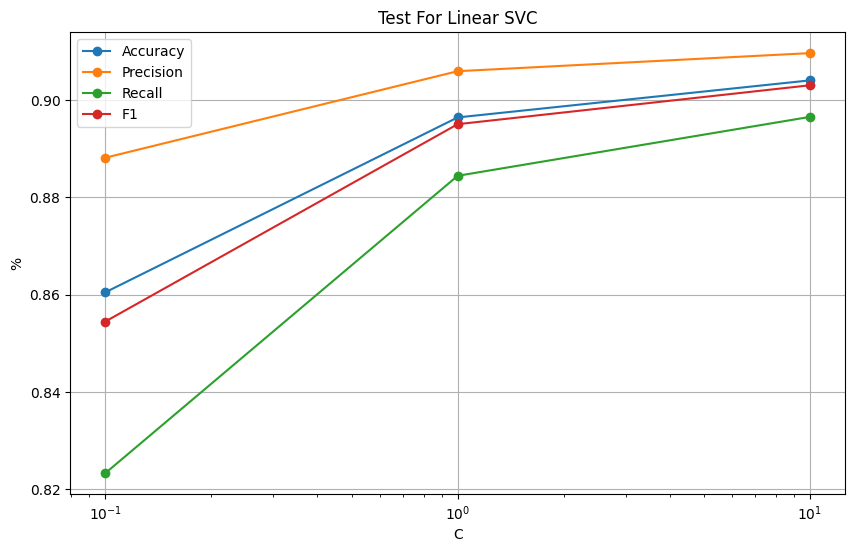

In [ ]:
C_values = [0.1, 1, 10]

accs, pres, recs, f1s = [], [], [], []





for C in C_values:

    print("--------------------")

    print(f"Mô Hình Linear SVC với C = {C}")

    print()

    acc, pre, rec, f1 = run_experiments(model_name="Linear SVC", X=X, y=y, n_trials=10, C=C)



    accs.append(acc)

    pres.append(pre)

    recs.append(rec)

    f1s.append(f1)



    print()



draw_chart_for_n_trials(C_values, accs, pres, recs, f1s, "Linear SVC", "C", is_log=True)

## Logistic Regression

--------------------
Mô Hình Logistic Regression với C = 0.1

Accuracy Hold-Out:  0.8494301563287947
F1 Hold-Out:  0.8459004805154704
Precision Hold-Out:  0.8645841227765305
Recall Hold-Out:  0.8280420222921769
Average Train Time Hold-Out: 2.1441 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0000125227 seconds
Model Size Hold-Out: 0.0770 MB

--------------------
Mô Hình Logistic Regression với C = 1

Accuracy Hold-Out:  0.8810590015128593
F1 Hold-Out:  0.8787816329522189
Precision Hold-Out:  0.8915195803764845
Recall Hold-Out:  0.8664152958868333
Average Train Time Hold-Out: 2.3131 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0000125406 seconds
Model Size Hold-Out: 0.0770 MB

--------------------
Mô Hình Logistic Regression với C = 10

Accuracy Hold-Out:  0.9043166918809884
F1 Hold-Out:  0.9031647689734827
Precision Hold-Out:  0.9110728887977576
Recall Hold-Out:  0.8954034408634357
Average Train Time Hold-Out: 2.6869 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0

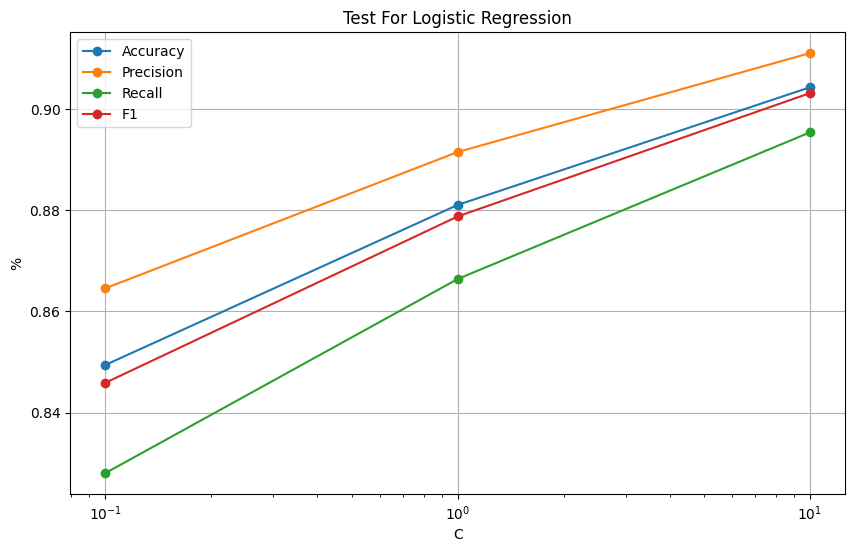

In [ ]:
C_values = [0.1, 1, 10]

accs, pres, recs, f1s = [], [], [], []

for C in C_values:

    print("--------------------")
    print(f"Mô Hình Logistic Regression với C = {C}")
    print()

    acc, pre, rec, f1 = run_experiments(model_name="Logistic Regression", X=X, y=y, n_trials=10, C=C)

    accs.append(acc)
    pres.append(pre)
    recs.append(rec)
    f1s.append(f1)

    print()

draw_chart_for_n_trials(C_values, accs, pres, recs, f1s, "Logistic Regression", "C", is_log=True)

## Random Forest

--------------------
Mô Hình Random Forest với n_estimators = 400, max_depth=30 và min_samples_leaf=50

Accuracy Hold-Out:  0.8224205748865355
F1 Hold-Out:  0.8086133861505038
Precision Hold-Out:  0.8697124283303108
Recall Hold-Out:  0.7563667254858686
Average Train Time Hold-Out: 27.2768 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0000913971 seconds
Model Size Hold-Out: 0.8348 MB

--------------------
Mô Hình Random Forest với n_estimators = 400, max_depth=20 và min_samples_leaf=20

Accuracy Hold-Out:  0.8361573373676248
F1 Hold-Out:  0.8256209471982362
Precision Hold-Out:  0.8756243406182552
Recall Hold-Out:  0.7815062336298021
Average Train Time Hold-Out: 39.6984 seconds
Average Test Time (for 1 sample) Hold-Out: 0.0001226542 seconds
Model Size Hold-Out: 1.3273 MB

--------------------
Mô Hình Random Forest với n_estimators = 300, max_depth=20 và min_samples_leaf=50

Accuracy Hold-Out:  0.8185879979828542
F1 Hold-Out:  0.803562120901584
Precision Hold-Out:  0.86880134088026

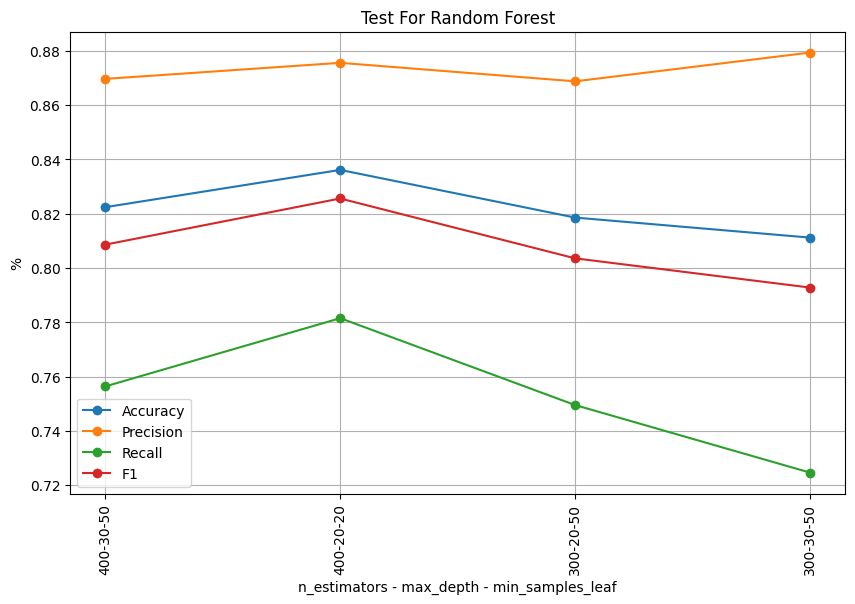

In [ ]:
accs, pres, recs, f1s = [], [], [], []

params = [
    [400, 30, 50],
    [400, 20, 20],
    [300, 20, 50],
    [300, 30, 50],
]

params_values = []


for param in params:

    print("--------------------")

    print(f"Mô Hình Random Forest với n_estimators = {param[0]}, max_depth={param[1]} và min_samples_leaf={param[2]}")

    print()

    acc, pre, rec, f1 = run_experiments(model_name="Random Forest", X=X, y=y, n_trials=10, n_estimators=param[0], max_depth=param[1], min_samples_leaf=param[2])



    params_values.append(f"{param[0]}-{param[1]}-{param[2]}")



    accs.append(acc)

    pres.append(pre)

    recs.append(rec)

    f1s.append(f1)



    print()



draw_chart_for_n_trials(params_values, accs, pres, recs, f1s, "Random Forest", "n_estimators - max_depth - min_samples_leaf", rotation=90)




## Vẽ biểu đồ thể hiện độ chính xác tốt nhất của từng mô hình

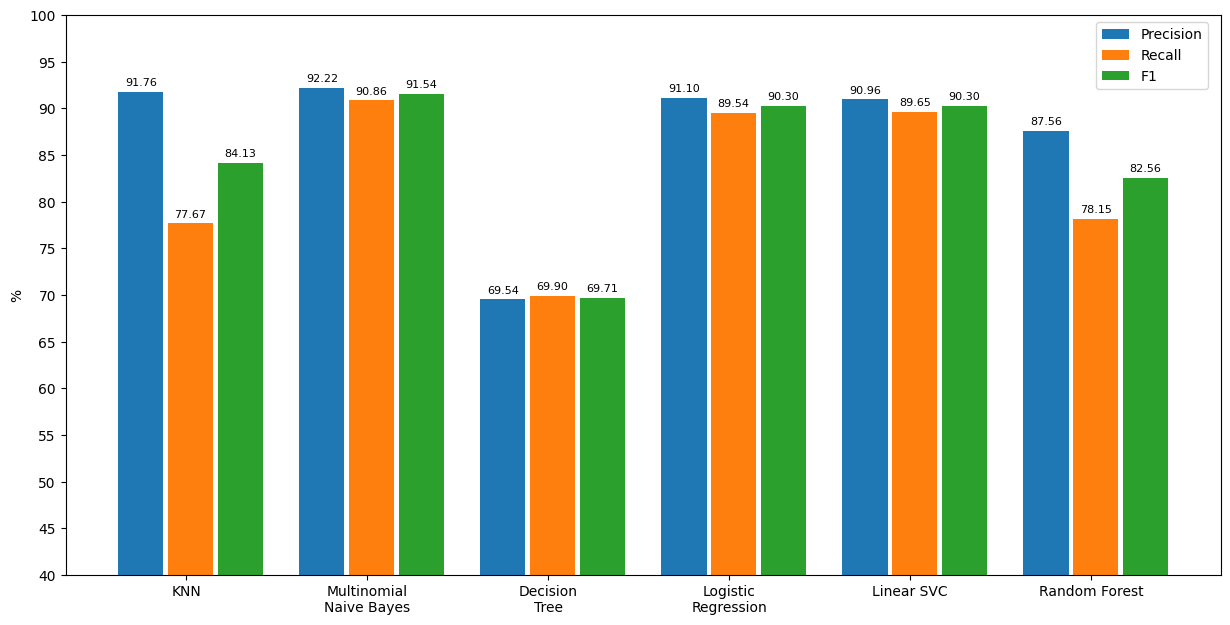

In [ ]:
groups = [

    [91.76, 92.22, 69.54, 91.10, 90.96, 87.56], # Precision

    [77.67, 90.86, 69.90, 89.54, 89.65, 78.15], # Recall

    [84.13, 91.54, 69.71, 90.30, 90.30, 82.56], # F1

]







# Thiết lập số nhóm

k = len(groups)



# Tạo vị trí cho từng nhóm cột

x = np.arange(len(groups[0]))  # vị trí cho các model name

width = 0.25  # Độ rộng của từng cột



# Vẽ biểu đồ cột

fig, ax = plt.subplots(figsize=(15, 8))



space = 0.05



# Vẽ các nhóm cột với độ dịch vị trí khác nhau

rects1 = ax.bar(x - width, groups[0], width, label='Precision')

rects2 = ax.bar(x + 0.5 * space, groups[1], width, label='Recall')

rects3 = ax.bar(x + width + space, groups[2], width, label='F1')



# Thêm giá trị lên các cột

ax.bar_label(rects1, padding=3, fmt='%.2f', fontsize=8)

ax.bar_label(rects2, padding=3, fmt='%.2f', fontsize=8)

ax.bar_label(rects3, padding=3, fmt='%.2f', fontsize=8)



# plt.xticks(rotation=30)

ax.set_yticks(np.arange(40, 101, 5))

ax.set_ylim(40, 100)



# Thêm các nhãn và tiêu đề

# ax.set_xlabel('Tên mô hình')

ax.set_ylabel('%')

# ax.set_title('Biểu đồ thể hiện độ chính xác tốt nhất của từng mô hình')

ax.set_xticks(x)

ax.set_xticklabels(['KNN', 'Multinomial\nNaive Bayes', 'Decision\nTree', 'Logistic\nRegression',

 'Linear SVC', 'Random Forest'], fontsize=10)  # Gắn model name dưới các cột

ax.legend(bbox_to_anchor=(0.995, 1))

# plt.tight_layout()



plt.subplots_adjust(top=0.90, bottom=0.20, left=0.08, right=0.85)

# Hiển thị biểu đồ

plt.savefig('/kaggle/working/best-res-chart.jpg', format='jpg', dpi=300)



plt.show()
